# Wide & Deep Learning model 구현

* 라이브러리 불러오기

In [117]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import os
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [118]:
df_merge = pd.read_csv('./data/Total_Data_1.csv')
df_merge = df_merge.sort_values(['sess_dt', 'hit_tm'])
df_merge.head()

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3,clnt_gender,clnt_age,label
121082,3390,1,1,0,A01,2019-07-01,00:00,0,NaN,지고트,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,Women's Outwear
194580,5535,1,1,5,A03,2019-07-01,00:00,6532,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,30,NaN
194581,5535,1,2,0,A03,2019-07-01,00:00,30494,NaN,양파,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,30,Chilled Instant Foods
194582,5535,1,3,3,A03,2019-07-01,00:00,32370,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,30,Chilled Beverages
194583,5535,1,4,0,A03,2019-07-01,00:00,41637,NaN,우엉,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,30,Snacks


In [119]:
df_merge.columns

Index(['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'biz_unit', 'sess_dt',
       'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm', 'cum_act_0', 'cum_act_1',
       'cum_act_2', 'cum_act_3', 'cum_act_4', 'cum_act_5', 'cum_act_6',
       'cum_act_7', 'day', 'holiday', 'hour', 'prefer_dvc_trfc', 'hum', 'temp',
       'pty', 'r06', 'act_kwd', 'sech_kwd_over_3', 'sech_kwd_cat_0',
       'sech_kwd_cat_1', 'sech_clac_nm1', 'sech_clac_nm2', 'trans_seq', 'pd_c',
       'de_dt', 'de_tm', 'buy_am', 'buy_ct', 'clac_nm1', 'clac_nm2',
       'clac_nm3', 'clnt_gender', 'clnt_age', 'label'],
      dtype='object')

In [120]:
df_merge.loc[df_merge['clac_nm2'].isnull(),'clac_nm2'] = df_merge['sech_clac_nm2']

In [121]:
df_merge = df_merge[['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'biz_unit', 'sess_dt',
       'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm', 'cum_act_0', 'cum_act_1',
       'cum_act_2', 'cum_act_3', 'cum_act_4', 'cum_act_5', 'cum_act_6',
       'cum_act_7', 'day', 'holiday', 'hour', 'prefer_dvc_trfc', 'hum', 'temp',
       'pty', 'r06', 'clac_nm2','clnt_gender', 'clnt_age']]

In [122]:
df_buyer = df_merge[(df_merge['action_type']==0)|(df_merge['action_type']==6)]

In [124]:
print('구매 이력이 있는 행:', round(len(df_buyer['clac_nm2']) / len(df_merge['clac_nm2']) * 100, 2),'%')

구매 이력이 있는 행: 24.55 %


In [125]:
del df_merge

In [126]:
sum(df_buyer['clac_nm2'].value_counts().head(19)) / sum(df_buyer['clac_nm2'].value_counts())

0.5151907367272397

In [127]:
# 유저 임베딩 데이터 load
user2vec = pd.read_csv('./data/user2vec100.csv')

In [128]:
df_buyer = df_buyer[df_buyer['clac_nm2'].notna()]
df_buyer = df_buyer.merge(user2vec, on=['clnt_id', 'sess_id'], how='left')

In [129]:
data = df_buyer.copy()

In [ ]:
drop_col=['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'hit_tm', 'trans_id', 'sess_dt', 'sech_kwd']
df_buyer = df_buyer.drop(drop_col, axis=1)

In [ ]:
le = LabelEncoder()

lab_len = len(df_buyer['clac_nm2'].value_counts())
label_key = df_buyer['clac_nm2'].value_counts().keys()

df_buyer['clac_nm2'] = le.fit_transform(df_buyer['clac_nm2'])
clac_nm2 = df_buyer['clac_nm2'].copy()
df_buyer.drop(['clac_nm2'], axis=1, inplace=True)

In [28]:
x_col = []
for i in range(100):
    x_col.append('X_'+str(i))

In [29]:
df_buyer.columns

Index(['biz_unit', 'hit_pss_tm', 'tot_pag_view_ct', 'tot_sess_hr_v',
       'trfc_src', 'dvc_ctg_nm', 'cum_act_0', 'cum_act_1', 'cum_act_2',
       'cum_act_3', 'cum_act_4', 'cum_act_5', 'cum_act_6', 'cum_act_7', 'day',
       'holiday', 'hour', 'prefer_dvc_trfc', 'hum', 'temp', 'pty', 'r06',
       'clnt_gender', 'clnt_age'],
      dtype='object')

In [30]:
df_buyer

,biz_unit,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,cum_act_0,cum_act_1,cum_act_2,cum_act_3,...,day,holiday,hour,prefer_dvc_trfc,hum,temp,pty,r06,clnt_gender,clnt_age
121082,A01,0,7.0,77.0,DIRECT,mobile_app,1,0,0,0,...,0,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,unknown,unknown
194581,A03,30494,13.0,263.0,DIRECT,mobile_app,1,0,0,0,...,0,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,F,30
194583,A03,41637,13.0,263.0,DIRECT,mobile_app,2,0,0,1,...,0,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,F,30
194584,A03,46474,13.0,263.0,DIRECT,mobile_app,3,0,0,1,...,0,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,F,30
194585,A03,48566,13.0,263.0,DIRECT,mobile_app,4,0,0,1,...,0,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,F,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591906,A03,1120520,49.0,1197.0,DIRECT,mobile_app,185,20,59,216,...,0,0,23,mobile_app_DIRECT,62.0,21.299999,0.0,0.0,F,30
591907,A03,1161158,49.0,1197.0,DIRECT,mobile_app,186,20,59,216,...,0,0,23,mobile_app_DIRECT,62.0,21.299999,0.0,0.0,F,30
2069190,A01,2059099,56.0,2059.0,PUSH,mobile_web,94,0,0,0,...,0,0,23,mobile_web_PUSH,62.0,21.299999,0.0,0.0,unknown,unknown
2300232,A03,3326381,26.0,3374.0,DIRECT,mobile_app,9,0,6,24,...,0,0,23,mobile_app_DIRECT,62.0,21.299999,0.0,0.0,unknown,unknown


In [31]:
df_buyer.columns

Index(['biz_unit', 'hit_pss_tm', 'tot_pag_view_ct', 'tot_sess_hr_v',
       'trfc_src', 'dvc_ctg_nm', 'cum_act_0', 'cum_act_1', 'cum_act_2',
       'cum_act_3', 'cum_act_4', 'cum_act_5', 'cum_act_6', 'cum_act_7', 'day',
       'holiday', 'hour', 'prefer_dvc_trfc', 'hum', 'temp', 'pty', 'r06',
       'clnt_gender', 'clnt_age'],
      dtype='object')

<br><br>
## 데이터 전처리

In [33]:
df_buyer[CATEGORICAL_COLUMNS].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659810 entries, 121082 to 3277694
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   biz_unit         659810 non-null  object 
 1   trfc_src         659810 non-null  object 
 2   dvc_ctg_nm       659810 non-null  object 
 3   prefer_dvc_trfc  659810 non-null  object 
 4   clnt_gender      659810 non-null  object 
 5   clnt_age         659810 non-null  object 
 6   pty              659810 non-null  float64
dtypes: float64(1), object(6)
memory usage: 60.3+ MB


In [32]:
ALL_COLUMNS = [
    'biz_unit', 'hit_pss_tm', 'tot_pag_view_ct', 'tot_sess_hr_v',  
       'trfc_src', 'dvc_ctg_nm', 'cum_act_0', 'cum_act_1', 'cum_act_2',
       'cum_act_3', 'cum_act_4', 'cum_act_5', 'cum_act_6', 'cum_act_7', 'day',
       'holiday', 'hour', 'prefer_dvc_trfc', 'hum', 'temp', 'pty', 'r06',
       'clnt_gender', 'clnt_age'
]

CATEGORICAL_COLUMNS = [
    "biz_unit", 'trfc_src', 'dvc_ctg_nm',  
    'prefer_dvc_trfc', 'clnt_gender', 'clnt_age', 'pty'
]

# EMBEDDED_COLUMNS = x_col

CONTINUOUS_COLUMNS = list(set(ALL_COLUMNS).difference(CATEGORICAL_COLUMNS))

In [35]:
df_buyer.loc[df_buyer['clnt_gender'].isnull(),'clnt_gender'] = 'U'
df_buyer.loc[df_buyer['clnt_age'].isnull(),'clnt_age'] =  -1

In [36]:
df_buyer[CATEGORICAL_COLUMNS]

,biz_unit,trfc_src,dvc_ctg_nm,prefer_dvc_trfc,clnt_gender,clnt_age,pty
121082,A01,DIRECT,mobile_app,mobile_app_DIRECT,unknown,unknown,0.0
194581,A03,DIRECT,mobile_app,mobile_app_DIRECT,F,30,0.0
194583,A03,DIRECT,mobile_app,mobile_app_DIRECT,F,30,0.0
194584,A03,DIRECT,mobile_app,mobile_app_DIRECT,F,30,0.0
194585,A03,DIRECT,mobile_app,mobile_app_DIRECT,F,30,0.0
...,...,...,...,...,...,...,...
591906,A03,DIRECT,mobile_app,mobile_app_DIRECT,F,30,0.0
591907,A03,DIRECT,mobile_app,mobile_app_DIRECT,F,30,0.0
2069190,A01,PUSH,mobile_web,mobile_web_PUSH,unknown,unknown,0.0
2300232,A03,DIRECT,mobile_app,mobile_app_DIRECT,unknown,unknown,0.0


In [37]:
for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    df_buyer[c] = le.fit_transform(df_buyer[c])

In [38]:
label = clac_nm2.copy()
label = np.eye(lab_len)[label]
label = pd.DataFrame(data=label, columns=label_key, index=df_buyer.index)

<br><br>
## Train 데이터, Test 데이터 분할

In [39]:
train_x, test_x , train_y , test_y = train_test_split(df_buyer , label , test_size=0.05, shuffle=False)

In [40]:
print('Train 데이터: ', train_x.shape)
print('Test 데이터: ', test_x.shape)
print('Train 라벨: ', train_y.shape)
print('Test 라벨: ', test_y.shape)

Train 데이터:  (626819, 24)
Test 데이터:  (32991, 24)
Train 라벨:  (626819, 309)
Test 라벨:  (32991, 309)


In [41]:
train_x, val_x , train_y , val_y = train_test_split(train_x , train_y , test_size=0.1, shuffle=False)

In [42]:
print('Train 데이터: ', train_x.shape)
print('Val 데이터: ', val_x.shape)
print('Train 라벨: ', train_y.shape)
print('Val 라벨: ', val_y.shape)

Train 데이터:  (564137, 24)
Val 데이터:  (62682, 24)
Train 라벨:  (564137, 309)
Val 라벨:  (62682, 309)


<br><br>
## Column 분할

In [43]:
train_x_category = np.array(train_x[CATEGORICAL_COLUMNS])
test_x_category  = np.array(test_x[CATEGORICAL_COLUMNS])
val_x_category   = np.array(val_x[CATEGORICAL_COLUMNS])

# train_x_embedding = np.array(train_x[EMBEDDED_COLUMNS])
# test_x_embedding  = np.array(test_x[EMBEDDED_COLUMNS])
# val_x_embedding   = np.array(val_x[EMBEDDED_COLUMNS])

train_x_continue = np.array(train_x[CONTINUOUS_COLUMNS], dtype='float64')
test_x_continue = np.array(test_x[CONTINUOUS_COLUMNS], dtype='float64')
val_x_continue = np.array(val_x[CONTINUOUS_COLUMNS], dtype='float64')

<br><br>
## 정규화

In [44]:
scaler = StandardScaler()
train_x_continue = scaler.fit_transform(train_x_continue)
test_x_continue = scaler.transform(test_x_continue)
val_x_continue = scaler.transform(val_x_continue)

* 정규화 내용 확인

In [45]:
print(train_x_continue[0].sum())
print(train_x_continue[1].sum())
print(train_x_continue[2].sum())
print(train_x_continue[3].sum())
print(train_x_continue[4].sum())

-11.605023918592604
-11.354365361540133
-11.324531784106052
-11.312471934166018
-11.302824361617715


<br><br>
## Polynomial 적용
    - 카테고리 값을 Polynomial로 바꿔줌

* sklearn.preprocessing.PolynomialFeatures 메소드
    - degree : 다항식 차수
    - interaction_only
        - default는 False
        - ex) degree = 3일 때, interaction_only=false 이면
            - a^2, a^3, b^2, b^3, ab, a^2*b, ab^2 Feature가 추가되고,
        - interaction_only=True 이면
            - ab만 추가됨
        

In [46]:
poly = PolynomialFeatures(degree=2, interaction_only=True)

In [47]:
train_x_category_poly = poly.fit_transform(train_x_category)
test_x_category_poly = poly.fit_transform(test_x_category)
val_x_category_poly = poly.fit_transform(val_x_category)

In [48]:
train_x_category_poly.shape

(564137, 29)

<br><br>
## 모델 구현

모델 구현에 대한 간단한 설명을 하겠습니다.  
입력은 2개로 분리해서 생각하면 됩니다.  

Wide 모델의 입력: category Feature을 Polynomial하게 바꿔준 데이터  
Deep 모델의 입력: category Feature을 embeding 시켜준 데이터 + continuous한 데이터  

그리고 출력은 lgbm 모델과 마찬가지로 1058개의 prediction 값이 row만큼 출력 됩니다.  

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from tensorflow.python.keras.optimizers import Adam, SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import Model
import tensorflow.keras.backend as K

<br>

### 하이퍼 파라미터 튜닝

In [50]:
beta_1 = 0.9
lr = 1e-5
l1 = 0.01
l2 = 0.01
momentum = 0.99

<br>

In [51]:
def get_deep_model():
    
    category_inputs = []
    category_embeds = []
    
    # Categorical Data Embedding
    for i in range(len(CATEGORICAL_COLUMNS)):
        
        # input - embedding - flatten 순으로 layer 쌓기
        input_i = Input(shape=(1,), dtype='int32')
        
        dim = len(np.unique(df_buyer[CATEGORICAL_COLUMNS[i]]))
        
        embed_dim = int(np.ceil(dim ** 0.5))
        
        embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
        # dim : 데이터가 몇 종류 있는지 = 임베딩 벡터를 몇 개 뽑아낼 것인지
        # embed_dim : 임베딩 처리 후 벡터의 차원 = 임베딩 벡터를 몇 차원 벡터로 뽑아 낼 것인지
        # input_length : 입력 데이터 길이
        
        flatten_i = Flatten()(embed_i)
        # category 값을 임베딩환 벡터들을 flatten
        
        category_inputs.append(input_i)
        category_embeds.append(flatten_i)
        
    # continuous 데이터 input
    continue_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
    continue_dense = Dense(256, use_bias=False)(continue_input)
    
    # category와 continue를 합침
    concat_embeds = concatenate([continue_dense] + category_embeds)
    concat_embeds = Activation('relu')(concat_embeds)
    
    bn_concat = BatchNormalization(momentum=momentum)( concat_embeds)
    
    fc1 = Dense(512, use_bias=False)(bn_concat)
    relu1 = ReLU()(fc1)
    bn1 = BatchNormalization()(relu1)
    fc2 = Dense(256, use_bias=False)(bn1)
    relu2 = ReLU()(fc2)
    bn2 = BatchNormalization()(relu2)
    fc3 = Dense(128)(bn2)
    deep = ReLU()(fc3)
#     dnn_hidden_units = [512 , 256 , 128 ]
#     reg = tf.keras.regularizers.L1L2(l1=l1, l2=l2)
#     for layerno, numnodes in enumerate(dnn_hidden_units):
#         deep = Dense(numnodes, 
#                      activation=None , 
#                      kernel_regularizer=reg , 
#                      name='dnn_{}'.format(layerno+1))(bn_concat)        
#         deep = BatchNormalization(momentum=momentum, name = "dnn_BN_{}".format(layerno+1))(deep)
#         deep = LeakyReLU( name = "dnn_LR_{}".format(layerno+1))(deep)
    
    return category_inputs, continue_input, deep

In [52]:
# x_train_category_poly : 카테고리 데이터를 숫자로 바꾸고, Poly Feature를 추가한 것
# Poly Feature : a, b, c Feature를 이용해서 ab, bc, ca Feature를 만든것
# 데이터의 shape 만 가져옴
def get_wide_model(poly):
    dim = poly.shape[1]
    return tf.keras.layers.Input(shape=(dim,))

def get_embed_model(embed):
    dim = embed.shape[1]
    return tf.keras.layers.Input(shape=(dim,))

In [53]:
# input - embedding - flatten 순으로 layer 쌓기
category_inputs, continue_input, deep_model = get_deep_model()
wide_model = get_wide_model(train_x_category_poly)
# embed_model = get_embed_model(train_x_embedding)

<br><br>
### Wide모델과 Deep model을 합치기

In [54]:
concat = concatenate([deep_model, wide_model])
inputs = [continue_input] + category_inputs + [wide_model] 
output = Dense(len(label_key), activation='sigmoid')(concat)
model = Model(inputs=inputs, outputs=output)

In [55]:
len(inputs)

9

<br><br>
### 입력 데이터

    * 위에서 정의한 리스트 변수 inputs에 맞추어
    * continue 데이터 => category 데이터 => poly data 순으로 입력 값을 넣어준다

In [56]:
input_data = [train_x_continue] + [train_x_category[:, i] for i in range(train_x_category.shape[1])] + [train_x_category_poly] 
val_data = [val_x_continue] + [val_x_category[:, i] for i in range(val_x_category.shape[1])] + [val_x_category_poly] 

<br><br>
## 학습 진행

In [57]:
def binary_crossentropy(y_true, y_pred):
    true = K.equal(y_true, 1.0 ) 
    true2 = K.cast(true , dtype = float)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

gamma = 2.0
epsilon = K.epsilon()

def focal_loss(y_true, y_pred):
    # https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss
    return K.mean(K.sum(loss, axis=1))

model.compile(optimizer=tf.keras.optimizers.Adam(lr, beta_1=beta_1),
              loss=focal_loss   , # focal_loss  ,  # 'binary_crossentropy',
              metrics=[ binary_crossentropy ]) 

In [58]:
checkpoint_path = "./ckpt/my_checkpoint/KM-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_loss',
                                                 save_best_only = True , 
                                                 save_freq = 'epoch' , 
                                                 mode='auto' ,
                                                 verbose=1)
# step 별로 learning rate를 조절합니다. 
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return tf.keras.callbacks.LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=lr, decay_factor=0.8, step_size=2)

  # `val_loss`가 2번의 에포크에 걸쳐 향상되지 않으면 훈련을 멈춥니다.
Early = tf.keras.callbacks.EarlyStopping(min_delta=0.0001, 
                                         patience=10 ,
                                         monitor='val_loss')

In [59]:
epochs = 500
batch_size = 128

In [60]:
history = model.fit(input_data, train_y, 
                  epochs=epochs, 
                  batch_size=batch_size, 
                  validation_data=(val_data, val_y), 
                  callbacks=[lr_sched, Early, cp_callback])

Epoch 1/500
4397/4408 [============================>.] - ETA: 0s - loss: 56.0090 - binary_crossentropy: 0.3224
Epoch 00001: val_loss improved from inf to 3.25890, saving model to ./ckpt/my_checkpoint/KM-0001.ckpt
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./ckpt/my_checkpoint/KM-0001.ckpt/assets
4408/4408 [==============================] - 13s 3ms/step - loss: 55.8853 - binary_crossentropy: 0.3218 - val_loss: 3.2589 - val_binary_crossentropy: 0.0681
Epoch 2/500
4394/4408 [============================>.] - ETA: 0s - loss: 2.6260 - binary_crossentropy: 0.0597
Epoch 00002: val_loss improved from 3.25890 to 2.27092, saving model to ./ckpt/my_checkpoint/KM-0002.ckpt
INFO:tensorflow:Assets written to: ./ckpt/my_checkpoint/KM-0002.ckpt/assets
4408/4408 [=================

In [61]:
model.save('./model/widendeep_model')

INFO:tensorflow:Assets written to: ./model/widendeep_model/assets


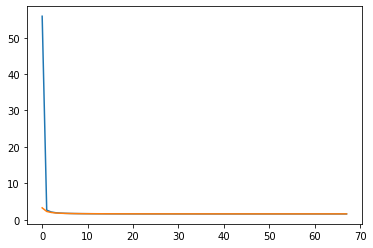

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

<br><br>
## 정확도 평가

In [63]:
# train input data와 같은 방식으로 test data를 input 형식에 맞추어줌
eval_input_data = [test_x_continue] + [test_x_category[:, i] for i in range(test_x_category.shape[1])] + [test_x_category_poly] 

In [64]:
loss, acc = model.evaluate(eval_input_data, test_y)

1031/1031 [==============================] - 1s 1ms/step - loss: 1.6108 - binary_crossentropy: 0.0663


In [66]:
prob = model.predict(eval_input_data)

In [115]:
data

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,holiday,hour,prefer_dvc_trfc,hum,temp,pty,r06,clac_nm2,clnt_gender,clnt_age
121082,3390,1,1,0,A01,2019-07-01,00:00,0,NaN,지고트,...,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,Women's Outwear,unknown,unknown
194581,5535,1,2,0,A03,2019-07-01,00:00,30494,NaN,양파,...,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,Chilled Instant Foods,F,30
194583,5535,1,4,0,A03,2019-07-01,00:00,41637,NaN,우엉,...,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,Snacks,F,30
194584,5535,1,5,0,A03,2019-07-01,00:00,46474,NaN,양파,...,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,Chilled Beverages,F,30
194585,5535,1,6,0,A03,2019-07-01,00:00,48566,NaN,양파,...,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,Chilled Instant Foods,F,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591906,14905,73,45,0,A03,2019-09-30,23:57,1120520,NaN,홈런볼,...,0,23,mobile_app_DIRECT,62.0,21.299999,0.0,0.0,Biscuits,F,30
591907,14905,73,46,0,A03,2019-09-30,23:58,1161158,NaN,조리퐁,...,0,23,mobile_app_DIRECT,62.0,21.299999,0.0,0.0,Biscuits,F,30
2069190,46858,16,27,0,A01,2019-09-30,23:58,2059099,NaN,등산모자,...,0,23,mobile_web_PUSH,62.0,21.299999,0.0,0.0,Camping,unknown,unknown
2300232,52023,3,30,6,A03,2019-09-30,23:58,3326381,112823.0,NaN,...,0,23,mobile_app_DIRECT,62.0,21.299999,0.0,0.0,Snacks,unknown,unknown


In [68]:
test_x.loc[:,'clnt_id'] = data.loc[test_x.index, 'clnt_id']
test_x.loc[:,'trans_id'] = data.loc[test_x.index, 'trans_id']

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [69]:
# one-hot에서 같은 trans_id는 더해줌.
receipt_y = test_y.copy()
receipt_y['trans_id'] = test_x['trans_id']
frame = pd.DataFrame(data = receipt_y['trans_id'], columns=['trans_id'])
receipt_y = receipt_y.groupby('trans_id', as_index=False).sum()
receipt_y = frame.merge(receipt_y, how='left').set_index(test_x.index)
receipt_y.drop('trans_id', axis=1, inplace=True)

In [70]:
receipt_y.head()

,Chilled Snacks,Snacks,Hot Snacks,Women's Upper Bodywear / Tops,Chilled Instant Foods,Bakery,Lighting Accessories,Biscuits,Ham and Sausages,Fish Cakes and Crab Sticks,...,Dried Sea Food Gift Sets,Grain Gift Sets,Writing Supplies,Car Accessories,Business Paper Products,Sea Food Gift Sets,Vegetable Gift Sets,Safety Equipment,Improvement Supplies,Car Wash Equipment
610899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2426791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# 같은 영수증 별로 구매 아이템을 묶어주는 작업.
test_label = data.loc[test_x.index][['clnt_id','sess_id', 'clac_nm2']]
frame = pd.DataFrame(data = test_label[['clnt_id','sess_id']], columns=['clnt_id', 'sess_id'])
test_label = test_label.groupby(['clnt_id','sess_id'])['clac_nm2'].apply(lambda x: ', '.join(x))
test_label = frame.merge(test_label, on=['clnt_id', 'sess_id'],how='left').set_index(test_x.index)

In [72]:
test_label.head(18).tail(5)

,clnt_id,sess_id,clac_nm2
1363259,31350,91,"Women's Lower Bodywear / Bottoms, Women's Lowe..."
1662350,37794,114,"Traditional Rice Cakes, Hot Snacks"
1662354,37794,114,"Traditional Rice Cakes, Hot Snacks"
2437753,54771,40,"Fish Cakes and Crab Sticks, Girl's Toys, Chill..."
2437755,54771,40,"Fish Cakes and Crab Sticks, Girl's Toys, Chill..."


In [73]:
score_pd = pd.DataFrame(prob, columns=receipt_y.columns)
cond = list(np.sum(receipt_y.values, axis=1) > 10)
cond_pd = score_pd[cond].reset_index(drop= True)
test_pd = test_label[cond].reset_index(drop= True)

In [75]:
''' 
pred_matrix: 예측된 아이템 행렬 파라미터.
top_n: 상위 몇개를 추천으로 사용할 지 정하는 파라미터.
test_matix: 고객ID와 Target이 있는 행렬 파라미터
'''
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    match_list = []
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        match = np.zeros(top_n).astype(np.int8).tolist()
        for j in range(len(top)):
            true_buy = [k for k in test_matix["clac_nm2"][i].split(', ')]
            if top[j] in true_buy :
                tmp += 1
                match[j] = 1
        match_list.append(match)
        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)
    print("Hit rate of Top {}: {:>.5f}".format(top_n, avg_acc))
    return avg_acc, match_list

In [77]:
def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)
    
def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

In [112]:
accuracy, match_list =  get_acc(cond_pd, 5 , test_pd) 
map_val = mean_average_precision(match_list)
print("MAP: {:.3}%".format(map_val*100))

Hit rate of Top 5: 0.00000
MAP: 0.0%


<br><br>
## 결과 시각화

In [79]:
def get_pred_list(predict_y, top_n, target_matrix):
    test_matrix = target_matrix.copy()
    pred_matrix = predict_y.copy()
    for i in range(len(pred_matrix)):
        top = pred_matrix.iloc[i].nlargest(top_n).index
        top = pd.DataFrame(top.astype(str).to_frame().apply(lambda x: ", ".join(x)))
        test_matrix.loc[i, 'pred'] = top.values[0]
    return test_matrix

In [80]:
d={'word': clac_nm2, 'label': data['clac_nm2']}
df = pd.DataFrame(data=d).drop_duplicates()
cate2papago = df.set_index('label').to_dict()

In [81]:
test = get_pred_list(cond_pd, 5, test_pd)

In [82]:
test

,clnt_id,sess_id,clac_nm2,pred
0,20299,12,"Chilled Instant Foods, Fish Cakes and Crab Sti...","Travel Bags, Fitness Training, Hand / Foot Car..."
1,20299,12,"Chilled Instant Foods, Fish Cakes and Crab Sti...","Travel Bags, Fitness Training, Hand / Foot Car..."
2,20299,12,"Chilled Instant Foods, Fish Cakes and Crab Sti...","Travel Bags, Fitness Training, Hand / Foot Car..."
3,20299,12,"Chilled Instant Foods, Fish Cakes and Crab Sti...","Travel Bags, Fitness Training, Hand / Foot Car..."
4,20299,12,"Chilled Instant Foods, Fish Cakes and Crab Sti...","Travel Bags, Fitness Training, Hand / Foot Car..."
...,...,...,...,...
2694,45745,35,"Chilled Snacks, Hot Snacks, Chilled Snacks, Pi...","Hand / Foot Care, Fitness Training, Travel Bag..."
2695,45745,35,"Chilled Snacks, Hot Snacks, Chilled Snacks, Pi...","Hand / Foot Care, Fitness Training, Travel Bag..."
2696,45745,35,"Chilled Snacks, Hot Snacks, Chilled Snacks, Pi...","Hand / Foot Care, Fitness Training, Travel Bag..."
2697,45745,35,"Chilled Snacks, Hot Snacks, Chilled Snacks, Pi...","Hand / Foot Care, Fitness Training, Travel Bag..."


In [83]:
test = test.groupby('sess_id', as_index=False).first()

In [84]:
def id_to_item(test, column_name):
    item_list = []
    for i in range(test.shape[0]):
        tmp_list = []
        for a in test.iloc[i][column_name].split(', '):
            tmp_list.append(a)
        item_list.append(tmp_list)
    return item_list

In [85]:
test

,sess_id,clnt_id,clac_nm2,pred
0,1,7090,"Instant Noodles, Dried Noodles, Dried Noodles,...","Travel Bags, Fitness Training, Boys' Full Body..."
1,2,63998,"Chilled Instant Foods, Lighting Accessories, F...","Fruit Vegetables, Hand / Foot Care, Mushrooms,..."
2,3,60449,"Packaged Side Dishes, Bakery, Hot Snacks, Seas...","Travel Bags, Hand / Foot Care, Fruit Vegetable..."
3,4,30297,"Eggs, Processed Seaweeds, Processed Seaweeds, ...","Women's General Sport Clothing, Hand / Foot Ca..."
4,5,24029,"Chilled Snacks, Chilled Snacks, Bakery, Chille...","Fruit Vegetables, Hand / Foot Care, Boys' Full..."
...,...,...,...,...
75,130,45092,"Ham and Sausages, Chilled Snacks, Ham and Saus...","Fruit Vegetables, Hand / Foot Care, Women's Ge..."
76,134,15518,"Biscuits, Processed Milk, Frozen Instant Foods...","Weight Training, Travel Bags, Chickens, Adults..."
77,138,35673,"Mushrooms, Yogurt, Biscuits, Frozen Instant Fo...","Hand / Foot Care, Mushrooms, Women's General S..."
78,196,62232,"Leaf Vegetables, Frozen Instant Foods, Tissues...","Hand / Foot Care, Fruit Vegetables, Girls' Out..."


In [86]:
a = id_to_item(test, 'clac_nm2')
b = id_to_item(test, 'pred')

In [87]:
list_x = []
for x in a:
    for i in x:
        list_x.append(i)

In [88]:
len(set(list_x))

137

In [96]:
list_x = []
for x in b:
    for i in x:
        list_x.append(i)

In [97]:
len(set(list_x))

29

In [98]:
def remove_dup(li):
        my_set = set()
        res = []
        for e in li:
            if e not in my_set:
                res.append(e)
                my_set.add(e)
        return res

In [99]:
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    match_list = []
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        match = np.zeros(top_n).astype(np.int8).tolist()
        for j in range(len(top)):
            true_buy = [k.split(", ")[0] for k in test_matix["clac_nm2"][i].split()]
            if top[j] in true_buy :
                tmp += 1
                match[j] = 1
        match_list.append(match)
        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)
    print("Hit rate of Top {}: {:>.5f}".format(top_n, avg_acc))
    return avg_acc, match_list

In [100]:
def show_with_table(a, b, index):
    buy_list = remove_dup(a[index])
    rec_list = remove_dup(b[index])
    tmp=[]
    match = np.zeros(len(b[index])).astype(np.int8).tolist()
    for j in range(len(rec_list)):
        if rec_list[j] in buy_list :
            tmp.append(str(j)+'번째: '+rec_list[j])
            match[j] = 1
    df1 = pd.DataFrame({"They buy": buy_list})
    df2 = pd.DataFrame({"We recommend" : rec_list})
    df = pd.concat([df1, df2], axis=1, sort=False)
    
    print(index, "번째 로그 데이터에 대한 결과\n")
    display(df)
    print("추천 적중 상품:", tmp)
    print("\nAP:", average_precision(match))

In [107]:
def find_good_case(a, b, criteria=0.5):
    good_map=[]
    for index in range(len(a)):
        buy_list = remove_dup(a[index])
        rec_list = remove_dup(b[index])
        match = np.zeros(len(b[index])).astype(np.int8).tolist()
        for j in range(len(rec_list)):
            if rec_list[j] in buy_list :
                match[j] = 1
        good_map.append(average_precision(match))
    best_idx = []
    for idx, v in enumerate(good_map):
        if v >= criteria:
            best_idx.append(idx)
    return best_idx

In [108]:
good_case_idx = find_good_case(a, b, 0.7)

In [109]:
show_with_table(a,b, good_case_idx[0])

2 번째 로그 데이터에 대해



,They buy,We recommend
0,Packaged Side Dishes,Travel Bags
1,Bakery,Hand / Foot Care
2,Hot Snacks,Fruit Vegetables
3,Seasoned Meats,Leaf Vegetables
4,Chickens,Fitness Training
5,Chilled Snacks,NaN
6,Travel Bags,NaN
7,Ham and Sausages,NaN
8,Snacks,NaN
9,Curtains / Blinds,NaN


추천 적중 상품: ['0번째: Travel Bags', '2번째: Fruit Vegetables', '3번째: Leaf Vegetables']

AP: 0.8055555555555555


### Entropy Diversity : 추천 결과가 얼마나 분산 되어 있느냐를 평가

In [102]:
import math
ideal = 'abcde'
probid = [ float(ideal.count(c)) / len(ideal) for c in dict.fromkeys(list(ideal))]
entropy_ideal = - sum([ p * math.log(p) / math.log(2.0) for p in probid ])

In [103]:
probid

[0.2, 0.2, 0.2, 0.2, 0.2]

In [104]:
entropy_ideal = - sum([ p * math.log(p) for p in probid])
entropy_ideal

1.6094379124341005

In [105]:
def entropy_diversity(li):
    total = []
    for first_list in li:
        for items in first_list:
            total.append(items)
    total_unique = list(set(total))
    probid = [ float(total.count(c)) / len(total) for c in total_unique]
    entropy_ideal = - sum([ p * math.log(p) for p in probid])
    return entropy_ideal

In [106]:
entropy_diversity(b)

2.497677095854723